In [1]:
%pip install pandas ufal.udpipe scikit-learn seaborn matplotlib numpy tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install conllu

In [70]:
import pandas as pd
import os
import re 
from ufal.udpipe import Model, Pipeline, ProcessingError 
import sys
import csv 
import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
import conllu 

In [71]:

#CODICE PER SISTEMARE GLI INDICI DEI CSV

from pathlib import Path


path = Path('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/output_gorman_no_anomalies_aggiornati_per_lemmi_e_postag')
lis_dir = [folder for folder in path.iterdir()]
for folder in lis_dir:
    for file in folder.glob('*.csv'):
        print(file) 
        df = pd.read_csv(file, sep=';')
        df = df.sort_values(by='@id').reset_index(drop=True)
        df['@id'] = range(1, len(df)+1)

        df.to_csv(file, sep=';', index=False)

C:\Users\lcolo\Desktop\TESI\CODICI DEFINITIVI DIZ UNICO-2\GORMAN\output_gorman_no_anomalies_aggiornati_per_lemmi_e_postag\aeschines-1-1-50-bu1.xml\0.csv
C:\Users\lcolo\Desktop\TESI\CODICI DEFINITIVI DIZ UNICO-2\GORMAN\output_gorman_no_anomalies_aggiornati_per_lemmi_e_postag\aeschines-1-1-50-bu1.xml\1.csv
C:\Users\lcolo\Desktop\TESI\CODICI DEFINITIVI DIZ UNICO-2\GORMAN\output_gorman_no_anomalies_aggiornati_per_lemmi_e_postag\aeschines-1-1-50-bu1.xml\10.csv
C:\Users\lcolo\Desktop\TESI\CODICI DEFINITIVI DIZ UNICO-2\GORMAN\output_gorman_no_anomalies_aggiornati_per_lemmi_e_postag\aeschines-1-1-50-bu1.xml\100.csv
C:\Users\lcolo\Desktop\TESI\CODICI DEFINITIVI DIZ UNICO-2\GORMAN\output_gorman_no_anomalies_aggiornati_per_lemmi_e_postag\aeschines-1-1-50-bu1.xml\101.csv
C:\Users\lcolo\Desktop\TESI\CODICI DEFINITIVI DIZ UNICO-2\GORMAN\output_gorman_no_anomalies_aggiornati_per_lemmi_e_postag\aeschines-1-1-50-bu1.xml\102.csv
C:\Users\lcolo\Desktop\TESI\CODICI DEFINITIVI DIZ UNICO-2\GORMAN\output_gor

In [72]:
#salvo tutte le directory delle opere
lis_dir = sorted(os.listdir('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/output_gorman_no_anomalies_aggiornati_per_lemmi_e_postag')) #inserire la directory giusta

In [73]:
lis_dir

['aeschines-1-1-50-bu1.xml',
 'aeschines-1-101-150-bu1.xml',
 'aeschines-1-151-196-bu1.xml',
 'aeschines-1-51-100-bu1.xml',
 'antiphon-1-bu2.xml',
 'antiphon-2-bu2.xml',
 'antiphon-5-bu2.xml',
 'antiphon-6-bu2.xml',
 'appian-bc-1-0-1-4-bu1.xml',
 'appian-bc-1-11-14-bu1.xml',
 'appian-bc-1-5-7-bu1.xml',
 'appian-bc-1-8-10-bu1.xml',
 'aristotle-politics-book-1-bu1.xml',
 'aristotle-politics-book-2-bu2.xml',
 'athen12-1-9-2019.xml',
 'athen12-10-19-2019.xml',
 'athen12-20-29-2019.xml',
 'athen12-30-39-jan-15.xml',
 'athen12-40-49-jan-15.xml',
 'athen12-50-59-jan-15.xml',
 'athen12-60-69-jan-15.xml',
 'athen12-70-81-jan-15.xml',
 'athen13-1-9-jan-15.xml',
 'athen13-10-19-jan-15.xml',
 'athen13-20-29-jan-15.xml',
 'athen13-30-39-jan-15.xml',
 'athen13-40-49-jan-15.xml',
 'athen13-50-59-jan-15.xml',
 'athen13-60-69-jan-15.xml',
 'athen13-70-79-jan-15.xml',
 'athen13-80-89-jan-15.xml',
 'athen13-90-95-jan-15.xml',
 'dem-59-neaira-2019.xml',
 'demosthenes-1-bu1.xml',
 'demosthenes-18-1-50-bu2.

Funzioni


In [74]:

def extract_number(file_path):
    # Use regex to find the numeric part of the filename
    return int(re.search(r'(\d+)\.csv$', file_path).group(1))


# --- FASE 1: CREAZIONE FILE CoNLL-U PRE-TOKENIZZATI ---

input_dir_gold = 'C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/output_gorman_no_anomalies_aggiornati_per_lemmi_e_postag' # Directory base del gold standard
output_dir_conllu = 'C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/input_conllu_for_udpipe_stanza_NO_ANOMALIES' # NUOVA directory per CoNLL-U



os.makedirs(output_dir_conllu, exist_ok=True)


for opera_dir_name in tqdm.tqdm(lis_dir):
    opera_gold_path = os.path.join(input_dir_gold, opera_dir_name)
    base_name = opera_dir_name.replace('.xml', '')
    output_conllu_path = os.path.join(output_dir_conllu, base_name + '.conllu')

    # Lista per contenere le righe CoNLL-U per l'intera opera
    conllu_output_lines = []
    sentence_counter = 0

    sentence_files = sorted(os.listdir(opera_gold_path), key=extract_number)

    for sentence_file in sentence_files:
        sentence_df_path = os.path.join(opera_gold_path, sentence_file)
        df_sentence = pd.read_csv(sentence_df_path, sep=';')
        df_sentence['@id'] = range(1, len(df_sentence)+1)
        
        # --- Genera CoNLL-U per la frase ---
        sentence_counter += 1
        sentence_text = " ".join(df_sentence["@form"].astype(str)) # Ricrea il testo della frase
        conllu_output_lines.append(f"# sent_id = {sentence_counter}")
        conllu_output_lines.append(f"# text = {sentence_text}")

        for _, row in df_sentence.iterrows():
            # CoNLL-U con solo ID e FORM, il resto placeholder (_)
            # Assicurati che l'ID sia una stringa o intero valido per CoNLL-U
            token_id = str(row['@id'])
            token_form = str(row['@form'])
            conllu_line = f"{token_id}\t{token_form}\t_\t_\t_\t_\t_\t_\t_\t_"
            conllu_output_lines.append(conllu_line)
        
        conllu_output_lines.append("")  # Riga vuota tra le frasi
    
    with open(output_conllu_path, "w", encoding="utf-8") as f:
        f.write("\n".join(conllu_output_lines))




def conllu_to_csv(input_file, output_file):
    # Assicurati che la directory di output esista
    output_dir = os.path.dirname(output_file)
    if output_dir: # Crea solo se non è vuoto
        os.makedirs(output_dir, exist_ok=True)

    with open(input_file, "r", encoding="utf-8") as conllu_file, open(output_file, "w", encoding="utf-8", newline="") as csv_file:
        writer = csv.writer(csv_file)
        
        # Scrive l'intestazione del CSV (adatta le colonne secondo il tuo caso)
        writer.writerow(["ID", "FORM", "LEMMA", "UPOS", "XPOS", "FEATS", "HEAD", "DEPREL", "DEPS", "MISC"])
        
        for line in conllu_file:
            line = line.strip()
            if not line or line.startswith("#"):
                # Ignora righe vuote e commenti
                continue
            # Divide la riga in colonne basandosi sulla tabulazione
            columns = line.split("\t")
            writer.writerow(columns)


# Function to evaluate predictions
def evaluate_predictions(predictions, gold_data):
    correct_lemmas = 0
    correct_pos = 0
    total = len(gold_data)
    wrong_lemmas = []
    wrong_postag = []

    for pred, gold in zip(predictions, gold_data):
        # Compare lemma
        if pred['LEMMA'] == gold['@lemma']:
            correct_lemmas += 1
        else:
            if gold['@lemma']!= 'punc1':
                wrong_lemmas.append([gold['@form'],gold['@lemma'],pred['LEMMA']])    
        # Compare POS tag
        if pred['XPOS'] == gold['@postag']:
            correct_pos += 1
        else:
            wrong_postag.append([gold['@form'],gold['@postag'],pred['XPOS']])    

    return total, correct_lemmas, correct_pos, pd.DataFrame(wrong_lemmas, columns = ['Form','Gold', 'Pred']), pd.DataFrame(wrong_postag, columns = ['Form','Gold', 'Pred']) 


# Function to evaluate predictions
def evaluate_predictions_per_position(predictions, gold_data):
    correct_lemmas = 0
    pos_accuracies = {i: [] for i in range(9)}  # Track accuracy for each position

    for pred, gold in zip(predictions, gold_data):
        # Compare lemma
        if pred['LEMMA'] == gold['@lemma']:
            correct_lemmas += 1

        # Compare POS tags by each character position, ensuring they are strings and of length 9
        gold_pos = str(gold['@postag'])
        pred_pos = str(pred['XPOS'])
        if type(gold_pos)==str:
          if len(gold_pos) == 9 and len(pred_pos) == 9:
              for i in range(9):
                  pos_accuracies[i].append(1 if pred_pos[i] == gold_pos[i] else 0)

    total = len(gold_data)
    return total, correct_lemmas, pos_accuracies

100%|██████████| 142/142 [06:48<00:00,  2.88s/it]


Preprocessing

UDPipe

In [4]:
#Scaricare il modello linguistico: Da runnare una sola volta, LO DEVO RIRUNNARE PER SCARICARE PROIEL
#!curl -k https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-3131/ancient_greek-proiel-ud-2.5-191206.udpipe -O ancient_greek-proiel-ud-2.5-191206.udpipe


Controllo importante! Dopo aver usato UDPipe, controllare che la lunghezza del dataframe finale corrisponda.

In [75]:
MODEL_PATHS = {
    'perseus': {
        'file': 'ancient_greek-perseus-ud-2.5-191206.udpipe',
        'url': 'https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-3131/ancient_greek-perseus-ud-2.5-191206.udpipe'
    },
    'proiel': {
        'file': 'C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/ancient_greek-proiel-ud-2.5-191206.udpipe',
        'url': 'https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-3131/ancient_greek-proiel-ud-2.5-191206.udpipe'
    }
}

In [76]:
#load the model for ancient greek
#model = Model.load(MODEL_PATHS['perseus']['file'])
model = Model.load(MODEL_PATHS['proiel']['file'])

In [77]:
if not model:                                           #dice solo se il modello è stato caricato
    sys.stderr.write("Cannot load model from file")
    sys.exit(1)
sys.stderr.write('done\n')

done


5

In [78]:
# Create a pipeline
pipeline = Pipeline(model, "conllu", Pipeline.DEFAULT, Pipeline.DEFAULT, "conllu")      #sto passando il modello, la modalità horizontal, le pipeline di lemma e pos, output in connllu

In [79]:
#COSA NON VA???

import glob
import os
import tqdm
from conllu import parse

input_dir = "C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/input_conllu_for_udpipe_stanza_NO_ANOMALIES"
output_dir = "C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/Output conllu udpipe CORRETTO PROIEL"

for input_file in tqdm.tqdm(glob.glob(os.path.join(input_dir, "*.conllu"))):
    filename = os.path.basename(input_file)
    output_file = os.path.join(output_dir, filename)

    try: 
        with open(input_file, "r", encoding="utf-8") as f:
            conllu_text = f.read()

        sentences = parse(conllu_text)

        processed_sentences = []
        for i, sentence in enumerate(sentences):
            conllu_str = sentence.serialize()
            result = pipeline.process(conllu_str)

            if not result.strip(): #mancano degli id in output  no anomalies 
                print(f"⚠️ Empty output for sentence {i+1} in file {filename}")
            else:
                processed_sentences.append(result)

        final_output = "\n".join(processed_sentences)

        with open(output_file, "w", encoding="utf-8") as f:
            f.write(final_output)

    except Exception as e:
        print(f"❌ Failed on file: {filename}")
        print(f"Error: {e}")

100%|██████████| 142/142 [15:59<00:00,  6.75s/it]


Performance

Accuracy overall per autore

In [80]:
#convert conllu to csv 
#Conversione degli output UDPipe conllu to csv

os.makedirs('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/Output conllu to csv udpipe CORRETTO PROIEL', exist_ok = True)

for opera in lis_dir:
    conllu_to_csv('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/Output conllu udpipe CORRETTO PROIEL/' + opera[:-4] + '.conllu','C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/Output conllu to csv udpipe CORRETTO PROIEL/' + opera[:-4] + '.csv')


In [81]:

#DEBUG PER CONTROLLARE CHE LA LUNGHEZZA DEI CSV DEL MODELLO E QUELLA DEI CSV GORMAN CON REALTION COINCIDANO: 

INPUT_FOLDER = "C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/output_gorman_no_anomalies_aggiornati_per_lemmi_e_postag/"

OUTPUT_CONLLU_TO_CSV_PATH = 'C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/Output conllu to csv udpipe CORRETTO PROIEL/'

# Scegli quale modello usare: 'perseus' oppure 'proiel'
MODEL_NAME = 'proiel'  # Cambia qui per scegliere il modello



all_opera_metrics = []

all_files = [f for f in os.listdir(INPUT_FOLDER)] 

for opera in all_files:
    # 2.1 Legge il file predetto da UDPipe (convertito in CSV)
    output_udpipe_path = os.path.join(OUTPUT_CONLLU_TO_CSV_PATH, opera[:-4] + '.csv')
    output_udpipe = pd.read_csv(output_udpipe_path)

    # 2.2 Legge i file CSV originali (gold standard)
    opera_folder = os.path.join(INPUT_FOLDER, opera)
    dfs_opera = sorted(os.listdir(opera_folder), key=extract_number)
    print(dfs_opera)
    dataframes_opera = [pd.read_csv(os.path.join(opera_folder, filename), sep=';') for filename in dfs_opera]
    all_opera = pd.concat(dataframes_opera, ignore_index=True)

    # 2.3 Converte i dati in formato 'lista di dizionari' per il confronto
    predictions = output_udpipe[['FORM', 'LEMMA', 'XPOS']].to_dict('records')
    gold_data = all_opera[['@form', '@lemma', '@postag']].to_dict('records')

    # 2.4 Controllo lunghezza
    if len(predictions) != len(gold_data):
        max_len = min(len(predictions), len(gold_data))
        for i in range(max_len):
            pred_form = predictions[i]['FORM'] if i < len(predictions) else "— (missing predizione)"
            gold_form = gold_data[i]['@form'] if i < len(gold_data) else "— (missing gold)"
            if pred_form != gold_form:
                print(f"❌ Disallineamento a indice {i}: FORM_PRED = {predictions[i]['FORM']} PRED='{pred_form}' | FORM_GOLD = {gold_data[i]['@form']} GOLD='{gold_form}'")
                #continue
            else:
                #print(f"Uguale indice {i}: PRED='{pred_form}' | GOLD='{gold_form}'")
                continue

['0.csv', '1.csv', '2.csv', '3.csv', '4.csv', '5.csv', '6.csv', '7.csv', '8.csv', '9.csv', '10.csv', '11.csv', '12.csv', '13.csv', '14.csv', '15.csv', '16.csv', '17.csv', '18.csv', '19.csv', '20.csv', '21.csv', '22.csv', '23.csv', '24.csv', '25.csv', '26.csv', '27.csv', '28.csv', '29.csv', '30.csv', '31.csv', '32.csv', '33.csv', '34.csv', '35.csv', '36.csv', '37.csv', '38.csv', '39.csv', '40.csv', '41.csv', '42.csv', '43.csv', '44.csv', '45.csv', '46.csv', '47.csv', '48.csv', '49.csv', '50.csv', '51.csv', '52.csv', '53.csv', '54.csv', '55.csv', '56.csv', '57.csv', '58.csv', '59.csv', '60.csv', '61.csv', '62.csv', '63.csv', '64.csv', '65.csv', '66.csv', '67.csv', '68.csv', '69.csv', '70.csv', '71.csv', '72.csv', '73.csv', '74.csv', '75.csv', '76.csv', '77.csv', '78.csv', '79.csv', '80.csv', '81.csv', '82.csv', '83.csv', '84.csv', '85.csv', '86.csv', '87.csv', '88.csv', '89.csv', '90.csv', '91.csv', '92.csv', '93.csv', '94.csv', '95.csv', '96.csv', '97.csv', '98.csv', '99.csv', '100.csv'

In [82]:
#Creo un dataframe per l'overall accuracy per opera su lemma e postag 
# #IL DATAFRAME CHE CREO MI DICE SUL TOTALE QUALTI LEMMI E QUANTI POSTAG UDPIPE HA AZZECCATO RISPETTO AL GOLD CON RELATION
#POI CONCATENA I RISULTATI IN UN UNICO DATAFRAME METTENDO LA PERCENTUALE DI ACCURACY PER OGNI OPERA SEPARATA, MOTIVO PER CUI MI SERVE FARE LA MEDIA

all_opera_metrics = []
for opera in lis_dir:
    output_udpipe = pd.read_csv('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/Output conllu to csv udpipe CORRETTO PROIEL/' + opera[:-4] + '.csv')
    dfs_opera = sorted(os.listdir('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/output_gorman_no_anomalies_aggiornati_per_lemmi_e_postag/'+ opera),key = extract_number)
    dataframes_opera = [pd.read_csv('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/output_gorman_no_anomalies_aggiornati_per_lemmi_e_postag' + '/' + opera + '/' + dir, sep=';') for dir in dfs_opera] #faccio una lista di dataframes (di frasi): Utile per Horizontal
    all_opera = pd.concat(dataframes_opera,ignore_index=True)
    print(output_udpipe)
    predictions = output_udpipe[['FORM', 'LEMMA', 'XPOS']].to_dict('records')       
    gold_data = all_opera [['@form', '@lemma', '@postag']].to_dict('records')
    #print(gold_data)
    results = {'total_words': [], 'correct_lemmas': [], 'correct_pos': []}
    # Evaluate predictions
    total_words, correct_lemmas, correct_pos,wrong_lem,wrong_postag = evaluate_predictions(predictions, gold_data)

    results['total_words'].append(total_words)
    results['correct_lemmas'].append(correct_lemmas)
    results['correct_pos'].append(correct_pos)


    # Convert the results into a DataFrame for easy viewing
    results_df = pd.DataFrame(results)

    # Calculate overall accuracy
    results_df['lemma_accuracy'] = results_df['correct_lemmas'] / results_df['total_words']
    results_df['pos_accuracy'] = results_df['correct_pos'] / results_df['total_words']

    all_opera_metrics.append(results_df)

all_opera_metrics = pd.concat(all_opera_metrics,axis=0,ignore_index=True)




      ID      FORM     LEMMA   UPOS XPOS  \
0      1    οὐδένα    οὐδείς    DET   Px   
1      2    πώποτε    πώποτε    ADV   Df   
2      3       τῶν         ὁ    DET   S-   
3      4   πολιτῶν   πολίτης   NOUN   Nb   
4      5         ,         ,  PUNCT    _   
...   ..       ...       ...    ...  ...   
4337  24       τὴν         ὁ   PRON   Pr   
4338  25       νῦν       νῦν    ADV   Df   
4339  26        οὐ        οὐ    ADV   Df   
4340  27  διέλιπον  διολείπω   VERB   V-   
4341  28         .         .  PUNCT    _   

                                                  FEATS  HEAD     DEPREL DEPS  \
0                      Case=Acc|Gender=Masc|Number=Sing     4        det    _   
1                                                     _    15     advmod    _   
2     Case=Gen|Definite=Def|Gender=Masc|Number=Plur|...     4        det    _   
3                      Case=Gen|Gender=Masc|Number=Plur     2        obl    _   
4                                                     _    15  dis

In [83]:
all_opera_metrics['opera'] = lis_dir        #aggiunge una nuova colonna per farmi sapere a cosa si riferiscono i numeri

In [84]:
all_opera_metrics = all_opera_metrics[['opera','total_words','correct_lemmas','correct_pos','lemma_accuracy','pos_accuracy']] 
#manipola il dataframe per dare nomi leggibili alle colonne

In [85]:
all_opera_metrics['lemma_accuracy'] = all_opera_metrics['lemma_accuracy'].round(3)
all_opera_metrics['pos_accuracy'] = all_opera_metrics['pos_accuracy'].round(3)

In [86]:
all_opera_metrics

opera  total_words  correct_lemmas  correct_pos  \
0       aeschines-1-1-50-bu1.xml         4342            2919            0   
1    aeschines-1-101-150-bu1.xml         3971            2608            0   
2    aeschines-1-151-196-bu1.xml         3704            2441            0   
3     aeschines-1-51-100-bu1.xml         3860            2584            0   
4             antiphon-1-bu2.xml         2040            1396            0   
..                           ...          ...             ...          ...   
137          xen-cyr-8-8-bu1.xml         1556            1145            0   
138       xen-hell-1-1-4-bu2.xml         4123            2943            0   
139       xen-hell-1-5-7-bu1.xml         4389            3049            0   
140           xen-hell-2-bu1.xml         9030            6344            0   
141           xen-hell-3-bu1.xml         9809            6982            0   

     lemma_accuracy  pos_accuracy  
0             0.672           0.0  
1             0.657           0.0  
2             0.659           0.0  
3             0.669           0.0  
4             0.684           0.0  
..              ...           ...  
137           0.736           0.0  
138           0.714           0.0  
139           0.695           0.0  
140           0.703           0.0  
141           0.712           0.0  

[142 rows x 6 columns]

In [87]:
all_opera_metrics.to_csv('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/accuracy_udpipe_per_opera_CORRETTO_PROIEL.csv')      

In [88]:
media_accuracy_lemma = round(all_opera_metrics['lemma_accuracy'].mean(), 3)
print(media_accuracy_lemma)

0.71


In [89]:
media_accuracy_postag = round(all_opera_metrics['pos_accuracy'].mean(), 3)
print(media_accuracy_postag)

0.0


In [90]:
lis_authors = [elem.split('-')[0] for elem in list(all_opera_metrics['opera'])] #serve per fare la lista degli autori
print(lis_authors)

['aeschines', 'aeschines', 'aeschines', 'aeschines', 'antiphon', 'antiphon', 'antiphon', 'antiphon', 'appian', 'appian', 'appian', 'appian', 'aristotle', 'aristotle', 'athen12', 'athen12', 'athen12', 'athen12', 'athen12', 'athen12', 'athen12', 'athen12', 'athen13', 'athen13', 'athen13', 'athen13', 'athen13', 'athen13', 'athen13', 'athen13', 'athen13', 'athen13', 'dem', 'demosthenes', 'demosthenes', 'demosthenes', 'demosthenes', 'demosthenes', 'demosthenes', 'demosthenes', 'demosthenes', 'demosthenes', 'demosthenes', 'demosthenes', 'demosthenes', 'demosthenes', 'demosthenes', 'diodsic', 'diodsic', 'diodsic11', 'diodsic11', 'diodsic11', 'dion', 'dion', 'dion', 'dion', 'dion', 'dion', 'hdt', 'hdt', 'hdt', 'hdt', 'hdt', 'hdt', 'hdt', 'hdt', 'hdt', 'hdt', 'josephus', 'josephus', 'josephus', 'josephus', 'josephus', 'josephus', 'lysias', 'lysias', 'lysias', 'lysias', 'lysias', 'lysias', 'lysias', 'plato', 'plut', 'plut', 'plut', 'plutarch', 'plutarch', 'plutarch', 'polybius', 'polybius', 'pol

In [91]:
author_occurencies = {elem: lis_authors.count(elem) for elem in set(lis_authors)}      
print(author_occurencies)
 #mette quante volte compare ciascun autore, crea dizionario dove le chiavi sono i nomi degli autori e i valori le occorrenze

{'athen12': 8, 'dion': 6, 'xen': 13, 'aeschines': 4, 'hdt': 10, 'dem': 1, 'demosthenes': 14, 'antiphon': 4, 'lysias': 7, 'plut': 3, 'plato': 1, 'aristotle': 2, 'ps': 1, 'diodsic': 2, 'athen13': 10, 'plutarch': 3, 'polybius1': 9, 'thuc': 9, 'appian': 4, 'diodsic11': 3, 'josephus': 6, 'polybius': 22}


In [92]:
#faccio una normalizzazione e fondo i nomi degli autori

per_author_metrics = []

for author in sorted(author_occurencies):
    results = {'author': author,'total_words': 0, 'correct_lemmas': 0, 'correct_pos': 0}
    for row in all_opera_metrics.iterrows():
        if row[1][0].split('-')[0]== author:
            results['total_words'] += row[1][1]
            results['correct_lemmas'] += row[1][2]
            results['correct_pos'] += row[1][3]
    #print([results])        
    results = pd.DataFrame([results])        
    results['lemma_accuracy'] = results['correct_lemmas'] / results['total_words']
    results['pos_accuracy'] = results['correct_pos'] / results['total_words']            
    per_author_metrics.append(results)
per_author_metrics = pd.concat(per_author_metrics,axis=0,ignore_index=True)

C:\Users\lcolo\AppData\Local\Temp\ipykernel_12940\1753186245.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[1][0].split('-')[0]== author:
C:\Users\lcolo\AppData\Local\Temp\ipykernel_12940\1753186245.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results['total_words'] += row[1][1]
C:\Users\lcolo\AppData\Local\Temp\ipykernel_12940\1753186245.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results['correct_lemmas

In [93]:
# Merging the rows
merge_pairs = {
    'athen': ['athen12', 'athen13'],
    'demosthenes': ['dem', 'demosthenes'],
    'diodsic': ['diodsic', 'diodsic11'],
    'plutarch': ['plut', 'plutarch'],
    'polybius': ['polybius', 'polybius1']
}

merged_rows = []
for group_name, authors in merge_pairs.items():
    subset = per_author_metrics[per_author_metrics['author'].isin(authors)]
    merged_row = {
        'author': group_name,
        'total_words': subset['total_words'].sum(),
        'correct_lemmas': subset['correct_lemmas'].sum(),
        'correct_pos': subset['correct_pos'].sum()
    }
    merged_row['lemma_accuracy'] = merged_row['correct_lemmas'] / merged_row['total_words']

    merged_row['pos_accuracy'] = merged_row['correct_pos'] / merged_row['total_words']

    merged_rows.append(merged_row)

# Keep rows that are not part of any merge group
remaining_df = per_author_metrics[~per_author_metrics['author'].isin([author for authors in merge_pairs.values() for author in authors])]

# Combine remaining rows with merged rows
per_unique_author_metrics= pd.concat([remaining_df, pd.DataFrame(merged_rows)], ignore_index=True)

per_unique_author_metrics['lemma_accuracy'] = per_unique_author_metrics['lemma_accuracy'].round(3)
per_unique_author_metrics['pos_accuracy'] = per_unique_author_metrics['pos_accuracy'].round(3)
per_unique_author_metrics


author  total_words  correct_lemmas  correct_pos  lemma_accuracy  \
0     aeschines        15877           10552            0           0.665   
1      antiphon        16373           11386            0           0.695   
2        appian        25649           17971            0           0.701   
3     aristotle        19836           14570            0           0.735   
4          dion        30120           21898            0           0.727   
5           hdt        33014           26407            0           0.800   
6      josephus        24891           17908            0           0.719   
7        lysias        22002           15225            0           0.692   
8         plato        10392            7135            0           0.687   
9            ps         3717            2672            0           0.719   
10         thuc        32189           22827            0           0.709   
11          xen        68522           48242            0           0.704   
12        athen        45088           30348            0           0.673   
13  demosthenes        66319           45157            0           0.681   
14      diodsic        25646           18873            0           0.736   
15     plutarch        36930           25462            0           0.689   
16     polybius       105254           76490            0           0.727   

    pos_accuracy  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
5            0.0  
6            0.0  
7            0.0  
8            0.0  
9            0.0  
10           0.0  
11           0.0  
12           0.0  
13           0.0  
14           0.0  
15           0.0  
16           0.0

In [94]:
per_unique_author_metrics.to_csv('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/accuracy_per_autore_udpipe_CORRETTO_PROIEL.csv') #tabella per tesi

In [95]:
author_dic = {
    'aristotle': ['aristotle'],
    'plato': ['plato'],
    'appian': ['appian'],
    'polybius': ['polybius', 'polybius1'],
    'diodsic': ['diodsic', 'diodsic11'],
    'xen': ['xen'],
    'athen': ['athen12', 'athen13'],
    'hdt': ['hdt'],
    'ps': ['ps'],
    'antiphon': ['antiphon'],
    'plut': ['plut', 'plutarch'],
    'josephus': ['josephus'],
    'aeschines': ['aeschines'],
    'thuc': ['thuc'],
    'dion': ['dion'],
    'dem': ['dem', 'demosthenes'],
    'lysias': ['lysias']
}


Accuracy per posizione, per autore

In [96]:
#Sto unendo i file originali e gli output udpipe per autore

author_udpipe = []
author_true = []
for author in sorted(author_dic):
    author_opera_list= []
    all_author_opera_true= []
    for opera in lis_dir:
        if opera.split('-')[0] in author_dic[author]:
            author_opera_list.append(opera)
    unified_data_udpipe = pd.concat([pd.read_csv('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/Output conllu to csv udpipe CORRETTO PROIEL/' + opera[:-4] + '.csv') for opera in author_opera_list],axis = 0, ignore_index=True)
    author_udpipe.append(unified_data_udpipe)
    for file in author_opera_list:
        dfs_opera = sorted(os.listdir('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/output_gorman_no_anomalies_aggiornati_per_lemmi_e_postag/'+ file),key = extract_number)
        dataframes_opera = [pd.read_csv('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/output_gorman_no_anomalies_aggiornati_per_lemmi_e_postag' + '/' + file + '/' + dir, sep=';') for dir in dfs_opera]
        all_opera = pd.concat(dataframes_opera,ignore_index=True)
        all_author_opera_true.append(all_opera)
    all_author_opera_true = pd.concat(all_author_opera_true,axis = 0, ignore_index=True) 
    author_true.append(all_author_opera_true)  


In [97]:
all_opera_position_accuracy = []
position_to_name = {
    0: 'pos',
    1: 'person',
    2: 'number',
    3: 'tense',
    4: 'mood',
    5: 'voice',
    6: 'gender',
    7: 'case',
    8: 'degree'
}

for i in range(len(author_dic)):

    predictions = author_udpipe[i][['FORM', 'LEMMA', 'XPOS']].to_dict('records')       
    gold_data = author_true[i][['@form', '@lemma', '@postag']].to_dict('records')
    results = {'total_words': [], 'correct_lemmas': [], 'correct_pos': []}
    # Evaluate predictions
    total_words, correct_lemmas, correct_pos,wrong_lem,wrong_postag = evaluate_predictions(predictions, gold_data)


    results = {'total_words': [], 'correct_lemmas': []}
    pos_position_accuracy = {i: [] for i in range(9)}

    # Evaluate predictions
    total_words, correct_lemmas, pos_accuracies = evaluate_predictions_per_position(predictions, gold_data)

    # Store the results, using opera name + file name as the identifier
    results['total_words'].append(total_words)
    results['correct_lemmas'].append(correct_lemmas)

    # Collect POS accuracy for each position
    for i in range(9):
        if pos_accuracies[i]:  # Ensure there are valid entries for this position
            pos_position_accuracy[i].append(sum(pos_accuracies[i]) / len(pos_accuracies[i]))

    # Convert the results into a DataFrame for easy viewing
    results_df = pd.DataFrame(results)

    # Calculate overall lemma accuracy
    results_df['lemma_accuracy'] = results_df['correct_lemmas'] / results_df['total_words']

    # Calculate mean and standard deviation for each POS position
    pos_position_stats = {
        position_to_name[i]: pos_position_accuracy[i]
        for i in range(9)
    }

    position_accuracy = pd.DataFrame(pos_position_stats)
    all_opera_position_accuracy.append(position_accuracy)
all_opera_position_accuracy_df = pd.concat(all_opera_position_accuracy,axis = 0,ignore_index=True)   
all_opera_position_accuracy_df = all_opera_position_accuracy_df.round(3)

In [98]:
all_opera_position_accuracy_df.insert(0, 'author', list(author_dic.keys()))

In [99]:
print(all_opera_position_accuracy_df)

       author  pos  person  number  tense  mood  voice  gender  case  degree
0   aristotle  NaN     NaN     NaN    NaN   NaN    NaN     NaN   NaN     NaN
1       plato  NaN     NaN     NaN    NaN   NaN    NaN     NaN   NaN     NaN
2      appian  NaN     NaN     NaN    NaN   NaN    NaN     NaN   NaN     NaN
3    polybius  NaN     NaN     NaN    NaN   NaN    NaN     NaN   NaN     NaN
4     diodsic  NaN     NaN     NaN    NaN   NaN    NaN     NaN   NaN     NaN
5         xen  NaN     NaN     NaN    NaN   NaN    NaN     NaN   NaN     NaN
6       athen  NaN     NaN     NaN    NaN   NaN    NaN     NaN   NaN     NaN
7         hdt  NaN     NaN     NaN    NaN   NaN    NaN     NaN   NaN     NaN
8          ps  NaN     NaN     NaN    NaN   NaN    NaN     NaN   NaN     NaN
9    antiphon  NaN     NaN     NaN    NaN   NaN    NaN     NaN   NaN     NaN
10       plut  NaN     NaN     NaN    NaN   NaN    NaN     NaN   NaN     NaN
11   josephus  NaN     NaN     NaN    NaN   NaN    NaN     NaN   NaN     NaN

In [100]:
all_opera_position_accuracy_df.to_csv('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/accuracy_autore_per_le_9_posizioni_udpipe_CORRETTO_PROIEL.csv') #TABELLA TESI

# Accuracy prima posizione per autore SONO ARRIVATA QUI CON LE MODIFICHE, CREA MAPPA!!!!!!!!

In [101]:
#lettere part of speech: nvadlgpcrmiu-

# Characters to evaluate in the first position of @postag
characters = list('nvadlgpcrmiu-')

In [102]:
author_udpipe[0] # devo creare la mappa che associ la prima lettera del postag con upos 

ID      FORM     LEMMA   UPOS XPOS  \
0       1    οὐδένα    οὐδείς    DET   Px   
1       2    πώποτε    πώποτε    ADV   Df   
2       3       τῶν         ὁ    DET   S-   
3       4   πολιτῶν   πολίτης   NOUN   Nb   
4       5         ,         ,  PUNCT    _   
...    ..       ...       ...    ...  ...   
15872   8  ἐμνήσθην  μιμνῄσκω   VERB   V-   
15873   9        ἐν        ἐν    ADP   R-   
15874  10        τῷ         ὁ    DET   S-   
15875  11      αὐτῷ     αὐτός    DET   Pd   
15876  12         .         .  PUNCT    _   

                                                   FEATS  HEAD     DEPREL  \
0                       Case=Acc|Gender=Masc|Number=Sing     4        det   
1                                                      _    15     advmod   
2      Case=Gen|Definite=Def|Gender=Masc|Number=Plur|...     4        det   
3                       Case=Gen|Gender=Masc|Number=Plur     2        obl   
4                                                      _    15  discourse   
...                                                  ...   ...        ...   
15872  Aspect=Perf|Mood=Ind|Number=Sing|Person=1|Tens...     0       root   
15873                                                  _    11       case   
15874  Case=Dat|Definite=Def|Gender=Masc,Neut|Number=...    11        det   
15875              Case=Dat|Gender=Masc,Neut|Number=Sing     8        obl   
15876                                                  _     8      xcomp   

      DEPS MISC  
0        _    _  
1        _    _  
2        _    _  
3        _    _  
4        _    _  
...    ...  ...  
15872    _    _  
15873    _    _  
15874    _    _  
15875    _    _  
15876    _    _  

[15877 rows x 10 columns]

In [103]:
author_udpipe[0]['XPOS'].str[0]  #prendo il primo carattere della colonna xpos del primo dataframe della lista author udpipe

0        P
1        D
2        S
3        N
4        _
        ..
15872    V
15873    R
15874    S
15875    P
15876    _
Name: XPOS, Length: 15877, dtype: object

In [104]:
results = []
# accuracy_results = {}
accuracy_res = {}
for i in range(len(author_udpipe)):
    # accuracy_results['author'] = list(sorted(author_dic.keys()))[i]
    # accuracy_results_ = {f"accuracy {char}": 0 for char in characters}
    
# Calculate accuracy for each character
    for char in characters:
        # Count matches where the first character of XPOS matches the first character of @postag
        total_matches = sum(
            (author_udpipe[i]['XPOS'].str[0] == char) & 
            (author_true[i]['@postag'].str[0] == char)
        )
    
        total_characters = sum(author_true[i]['@postag'].str[0] == char)
        accuracy_res[f"{char}"] = total_matches / total_characters if total_characters > 0 else 0
    results.append(pd.DataFrame([accuracy_res]))

    # Convert results to DataFrame
final_results = pd.concat(results,axis = 0,ignore_index = True)
final_results


n    v    a    d    l  g    p    c    r    m    i    u  -
0   0.0  0.0  0.0  0.0  0.0  0  0.0  0.0  0.0  0.0  0.0  0.0  0
1   0.0  0.0  0.0  0.0  0.0  0  0.0  0.0  0.0  0.0  0.0  0.0  0
2   0.0  0.0  0.0  0.0  0.0  0  0.0  0.0  0.0  0.0  0.0  0.0  0
3   0.0  0.0  0.0  0.0  0.0  0  0.0  0.0  0.0  0.0  0.0  0.0  0
4   0.0  0.0  0.0  0.0  0.0  0  0.0  0.0  0.0  0.0  0.0  0.0  0
5   0.0  0.0  0.0  0.0  0.0  0  0.0  0.0  0.0  0.0  0.0  0.0  0
6   0.0  0.0  0.0  0.0  0.0  0  0.0  0.0  0.0  0.0  0.0  0.0  0
7   0.0  0.0  0.0  0.0  0.0  0  0.0  0.0  0.0  0.0  0.0  0.0  0
8   0.0  0.0  0.0  0.0  0.0  0  0.0  0.0  0.0  0.0  0.0  0.0  0
9   0.0  0.0  0.0  0.0  0.0  0  0.0  0.0  0.0  0.0  0.0  0.0  0
10  0.0  0.0  0.0  0.0  0.0  0  0.0  0.0  0.0  0.0  0.0  0.0  0
11  0.0  0.0  0.0  0.0  0.0  0  0.0  0.0  0.0  0.0  0.0  0.0  0
12  0.0  0.0  0.0  0.0  0.0  0  0.0  0.0  0.0  0.0  0.0  0.0  0
13  0.0  0.0  0.0  0.0  0.0  0  0.0  0.0  0.0  0.0  0.0  0.0  0
14  0.0  0.0  0.0  0.0  0.0  0  0.0  0.0  0.0  0.0  0.0  0.0  0
15  0.0  0.0  0.0  0.0  0.0  0  0.0  0.0  0.0  0.0  0.0  0.0  0
16  0.0  0.0  0.0  0.0  0.0  0  0.0  0.0  0.0  0.0  0.0  0.0  0

In [105]:
#Questo al momento dà errore per uno spiecifico autore per un misalignement di lunghezza. Da controllare all'inizio.

results = []

# Iterate over authors
for i in range(len(author_udpipe)):
    author_name = list(sorted(author_dic.keys()))[i]
    
    # Initialize a list to store results for this author
    author_result = []
    
    # Extract prediction and ground truth DataFrames for this author
    udpipe_df = author_udpipe[i].reset_index(drop=True)
    true_df = author_true[i].reset_index(drop=True)

    # --- Controllo Fondamentale della Lunghezza ---
    if len(udpipe_df) != len(true_df):
        print(f"⚠️ ATTENZIONE: Lunghezze diverse per l'autore '{author_name}'.")
        print(f"  - Lunghezza Dati UDPipe: {len(udpipe_df)}")
        print(f"  - Lunghezza Dati Gold:   {len(true_df)}")
        print(f"  >> Questo autore verrà saltato nell'analisi delle frequenze.")
        continue
    
    for char in characters:
        # Filter rows where the true first character of @postag matches the current char
        true_char_filter = true_df['@postag'].str[0] == char
        
        # Extract corresponding predicted characters for these rows
        predicted_chars = udpipe_df.loc[true_char_filter, 'XPOS'].str[0]
        
        # Calculate frequencies of predicted characters
        predicted_frequencies = predicted_chars.value_counts().to_dict()
        
        # Create a row for this char
        char_result = {
            "author": author_name,
            "char": char,
            "predicted frequencies": predicted_frequencies
        }
        author_result.append(char_result)
    
    # Append the result for this author
    results.extend(author_result)

# Convert results to a DataFrame
final_results_freq = pd.DataFrame(results)

In [106]:
final_results_freq #2205 volte il nome è stato predetto nome, 153 volte il nome è stato predetto aggettivo etc -> è quello che poi vedo nelle matrici di confusione

author char                              predicted frequencies
0    aeschines    n  {'N': 2246, 'A': 104, 'V': 52, 'P': 9, 'M': 8,...
1    aeschines    v  {'V': 2798, 'N': 52, 'A': 12, 'D': 9, 'P': 3, ...
2    aeschines    a  {'A': 703, 'P': 340, 'N': 161, 'M': 68, 'V': 4...
3    aeschines    d  {'D': 1454, 'C': 249, 'V': 222, 'N': 60, 'G': ...
4    aeschines    l      {'S': 1813, 'V': 25, 'P': 21, 'N': 1, 'D': 1}
..         ...  ...                                                ...
216        xen    r  {'R': 3160, 'V': 267, 'D': 21, 'A': 12, 'P': 1...
217        xen    m                {'M': 254, 'V': 11, 'N': 2, 'A': 2}
218        xen    i                         {'I': 225, 'N': 1, 'V': 1}
219        xen    u                                        {'_': 8245}
220        xen    -                                                 {}

[221 rows x 3 columns]

Accuracy della lemmatizzazione dato il postag

In [107]:
def calculate_accuracy_with_authors(author_updpipe, author_true, author_list):
    """
    Calcola l'accuratezza della lemmatizzazione per autore e per categoria di tag Part-of-Speech (POS).

    Confronta i lemmi generati da UDPipe con i lemmi di riferimento per diversi autori,
    raggruppando il calcolo dell'accuratezza per la prima lettera del tag Part-of-Speech (POS) di riferimento.

    Args:
        author_updpipe (list[pd.DataFrame]): Una lista di DataFrames, dove ogni DataFrame
                                            contiene le annotazioni di UDPipe (inclusa una colonna 'LEMMA')
                                            per un autore specifico.
        author_true (list[pd.DataFrame]): Una lista di DataFrames, dove ogni DataFrame
                                         contiene le annotazioni di riferimento (inclusa una colonna '@lemma'
                                         e una colonna '@postag') per l'autore corrispondente.
        author_list (list[str]): Una lista di nomi di autori corrispondenti ai DataFrames
                                 in author_updpipe e author_true.

    Returns:
        tuple: Una tupla contenente:
            - pd.DataFrame: Un DataFrame dove ogni riga rappresenta un autore, e le colonne
                            mostrano l'accuratezza della lemmatizzazione per ogni categoria di tag Part-of-Speech
                            (e.g., 'accuracy_lemma_n' per i nomi, 'accuracy_lemma_v' per i verbi).
            - set: Un set contenente le prime lettere uniche dei tag Part-of-Speech presenti in tutti gli autori.
    """
    results = []
    pos_list = []
   
    for updpipe_df, true_df, author_name in zip(author_updpipe, author_true, author_list):
        # Concatenare i dati lungo le colonne
        combined_df = pd.concat([updpipe_df.reset_index(drop=True), true_df.reset_index(drop=True)], axis=1)
       
        # Calcolare accuratezza per la prima lettera del postag
        combined_df['POSTAG_FIRST'] = combined_df['@postag'].str[0]
        pos_groups = combined_df.groupby('POSTAG_FIRST')
       
        accuracies = {'author': author_name}
        for pos, group in pos_groups:
            if pos == 'δ':
                print(pos, group)
            total = len(group)
            correct = (group['LEMMA'] == group['@lemma']).sum()
            accuracies[f"accuracy_lemma_{pos}"] = correct / total if total > 0 else 0
            accuracies[f"accuracy_lemma_{pos}"] = np.round(accuracies[f"accuracy_lemma_{pos}"],2)
            #print(pos)
            pos_list.append(pos)
        results.append(accuracies)
   
    # Trasformare i risultati in un DataFrame per una visione chiara
    results_df = pd.DataFrame(results)
   
    return results_df, set(pos_list)



In [108]:
author_list = list(sorted(author_dic.keys()))

In [109]:
for df_index, (true_df, author_name) in enumerate(zip(author_true, author_list)):
    true_df['@postag'] = true_df['@postag'].astype(str)
    delta_rows = true_df[true_df['@postag'].str.startswith('δ', na=False)]
    if not delta_rows.empty:
        print(author_name)
        print(delta_rows)
        print(df_index)

#PROBLEMA ESCE UN DELTA CHE PERO' IN OUTPUT GORMAN CON RELATION NON ESISTE

In [110]:
accuracy_lemma_by_pos,pos_list = calculate_accuracy_with_authors(author_udpipe, author_true,author_list)

In [111]:
accuracy_lemma_by_pos.to_csv('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/lemmi_corretti_per_postagging_udpipe_CORRETTO_PROIEL.csv') #tabella tesi

In [112]:
print(accuracy_lemma_by_pos) #QUANTI LEMMI DI ARTICOLO HA AZZECCATO, QUANTI LEMMI DI AGGETTIVO ETC??

       author  accuracy_lemma_a  accuracy_lemma_c  accuracy_lemma_d  \
0   aeschines              0.75              0.85              0.73   
1    antiphon              0.80              0.85              0.76   
2      appian              0.77              0.89              0.82   
3   aristotle              0.73              0.86              0.78   
4       athen              0.70              0.89              0.74   
5         dem              0.74              0.88              0.78   
6     diodsic              0.76              0.93              0.82   
7        dion              0.72              0.91              0.86   
8         hdt              0.89              0.93              0.87   
9    josephus              0.72              0.90              0.80   
10     lysias              0.79              0.88              0.80   
11      plato              0.80              0.87              0.80   
12       plut              0.71              0.89              0.77   
13   p

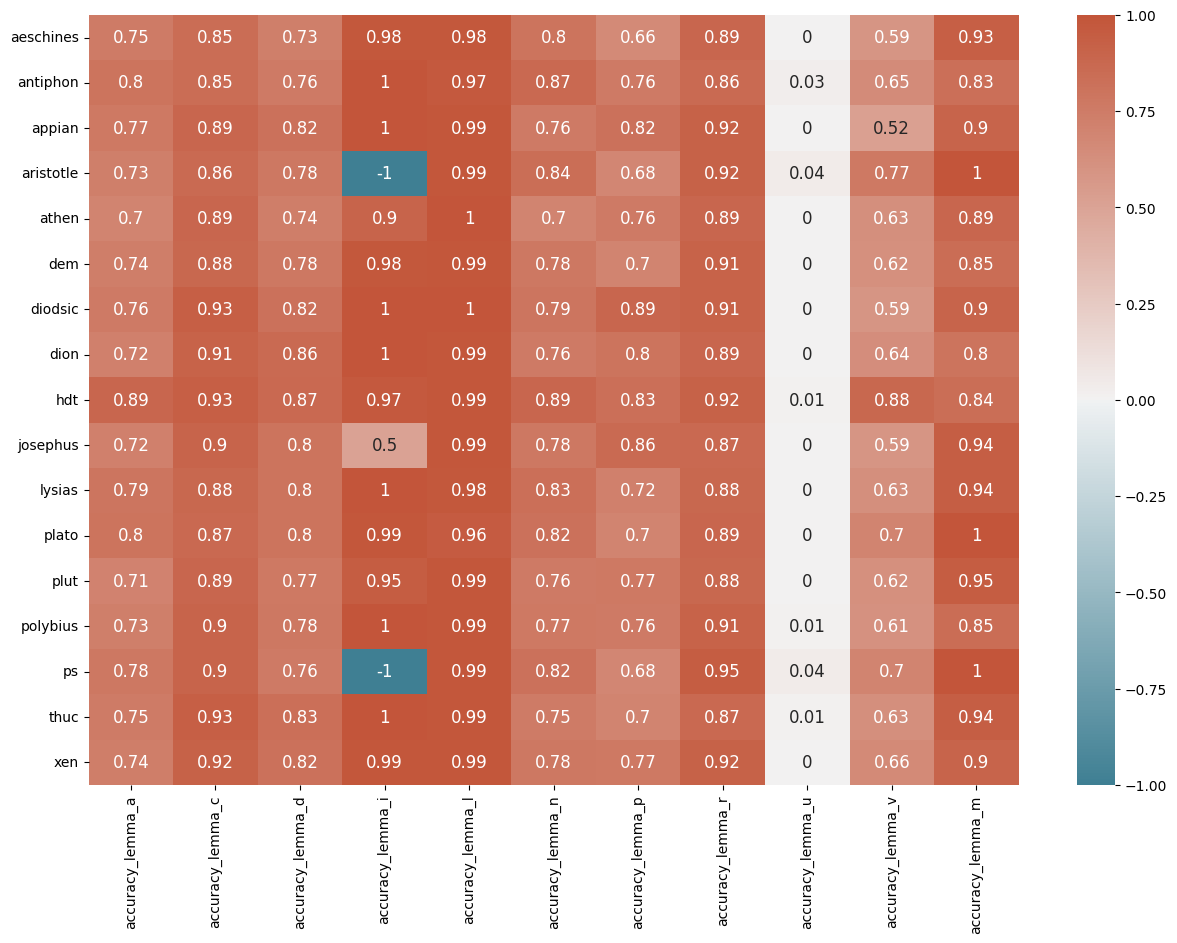

In [113]:
sub_cols = [ 'accuracy_lemma_a', 'accuracy_lemma_c',
       'accuracy_lemma_d', 'accuracy_lemma_i', 'accuracy_lemma_l',
       'accuracy_lemma_n', 'accuracy_lemma_p', 'accuracy_lemma_r',
       'accuracy_lemma_u', 'accuracy_lemma_v', 'accuracy_lemma_m']
sub_df = accuracy_lemma_by_pos[sub_cols]
sub_df = sub_df.fillna(-1)
cmap = sns.diverging_palette(220, 20, as_cmap = True)
plt.figure(figsize = (15,10))
sns.heatmap(sub_df, cmap=cmap, center=0, annot=sub_df, fmt='g',
                xticklabels=sub_cols, yticklabels=author_list,
                annot_kws={'size': 12})
plt.show()
#ROSSO SCURO 1 AZZECCATO DI PIU, BIANCO 0 NON LI HA AZZECCATI. -1 INDICA NAN QUINDI VUOL DIRE CHE NEL GOLD STANDARD NON C'ERA T ES. 

matrici di confusione

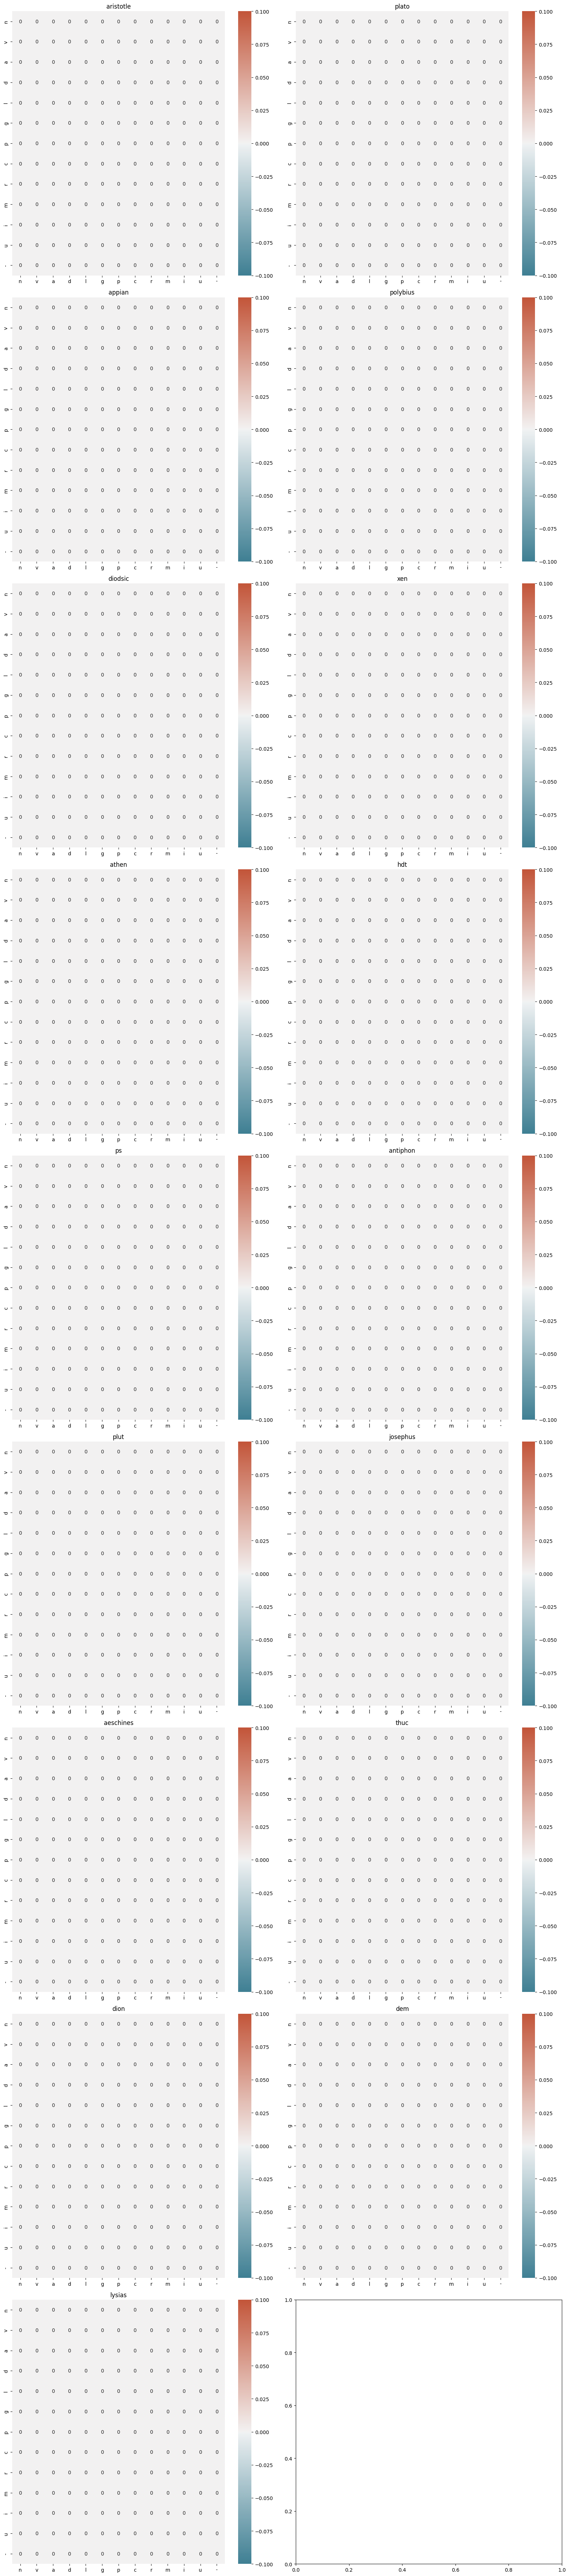

In [47]:
# Assuming 'author_dic', 'author_udpipe', and 'author_true' are defined
author_keys = list(author_dic.keys())
num_plots = len(author_keys)

# Define labels
lab_prima_posizione = 'n v a d l g p c r m i u -'.split(' ')

# Determine grid size (e.g., 3 columns, rows computed accordingly)
cols = 2
rows = math.ceil(num_plots / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*8, rows*8))

cmap = sns.diverging_palette(220, 20, as_cmap=True)

for i, key in enumerate(author_keys):
    predictions = author_udpipe[i][['FORM', 'LEMMA', 'XPOS']].to_dict('records')
    gold_data = author_true[i][['@form', '@lemma', '@postag']].to_dict('records')

    pred_list = []
    gold_list = []
    for pred, gold in zip(predictions, gold_data):
        gold_pos = str(gold['@postag'])
        pred_pos = str(pred['XPOS'])
        # Extract only the first character
        pred_list.append(pred_pos[0])
        gold_list.append(gold_pos[0])

    # Compute confusion matrix
    cm = confusion_matrix(gold_list, pred_list, labels=lab_prima_posizione)

    # Determine the subplot location
    row = i // cols
    col = i % cols

    # If you have a single row, axes might not be 2D
    ax = axes[row, col] if rows > 1 else axes[col]

    # Plot the heatmap on the given axis
    
    sns.heatmap(cm, cmap=cmap, annot=cm, fmt='d',
                xticklabels=lab_prima_posizione, yticklabels=lab_prima_posizione,
                annot_kws={'size': 10}, ax=ax)
    ax.set_title(key)

# Adjust layout for clarity
plt.tight_layout()
plt.show()

In [48]:
''''
sulla diagonale troviamo i valori classificati correttamente. es. 2205 n è stato classificato come n 
sommando ciascuna riga ottengo il  numero di una classe all'interno del totale delle label. esempo 2205 + 151 + 153 è il numero di 
n in gold_list. Es. di tutti gli n, 2205 sono classificati come n, 151 come v e 153 come a, 7 come d etc...
Sommando le colonne trovi il totale di una classe all'interno delle predizioni (pred_list).Es. 2205 + 71 + 162 + 17 etc... è il totale di n che 
trovi nell'array delle predizioni 
Es 2205 sono n classificati come n, 71 v class come n, 162 sono a classificati come n, 17 sono d classificati come n)
'''

"'\nsulla diagonale troviamo i valori classificati correttamente. es. 2205 n è stato classificato come n \nsommando ciascuna riga ottengo il  numero di una classe all'interno del totale delle label. esempo 2205 + 151 + 153 è il numero di \nn in gold_list. Es. di tutti gli n, 2205 sono classificati come n, 151 come v e 153 come a, 7 come d etc...\nSommando le colonne trovi il totale di una classe all'interno delle predizioni (pred_list).Es. 2205 + 71 + 162 + 17 etc... è il totale di n che \ntrovi nell'array delle predizioni \nEs 2205 sono n classificati come n, 71 v class come n, 162 sono a classificati come n, 17 sono d classificati come n)\n"

In [49]:
print(model.get_model_info())

AttributeError: 'ufal.udpipe.Model' object has no attribute 'get_model_info'